# MLNS ASSIGNEMENT - MISSING LINK PREDICTION

## I - INITIALISING ENVIRONMENT

In [46]:
import numpy as np
import csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from torch_geometric.data import Data
import torch
import torch.nn as nn
import dgl
from dgl.nn import GraphConv
import torch.nn.functional as F

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

from sklearn.metrics.pairwise import cosine_similarity

from torch_geometric.nn import GCNConv

In [47]:
node_info = pd.read_csv("../data/node_information.csv", header=None, index_col=0)
test_set = pd.read_csv("../data/test.txt", sep=" ", header=None, names=['source', 'target'])
train_set = pd.read_csv("../data/train.txt", sep=" ", header=None, names=['source', 'target', 'label'])

test_set_final = pd.read_csv("../test_set_final.csv")
train_set_final = pd.read_csv("../train_set_final.csv")

In [16]:
test_col = test_set_final.columns

In [8]:
print(node_info.shape)
node_info.head(-5)

(3597, 932)


,1,2,3,4,5,6,7,8,9,10,...,923,924,925,926,927,928,929,930,931,932
0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


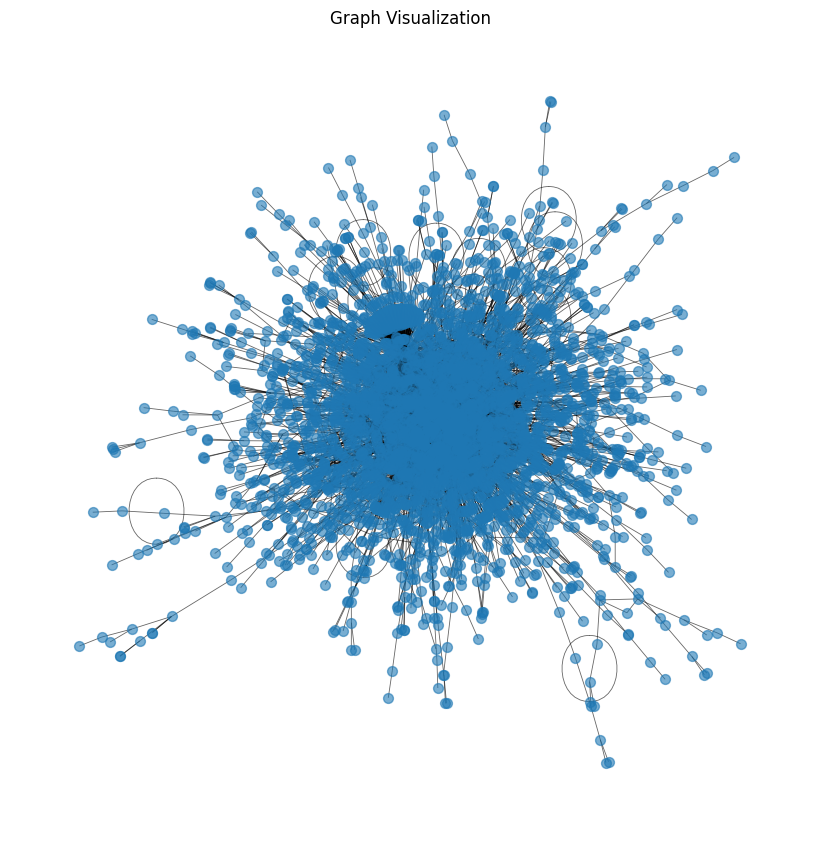

In [48]:
edges = train_set[train_set['label'] == 1][['source', 'target']].values.tolist()

G = nx.Graph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=False, node_size = 50, alpha = 0.6, width = 0.6)
plt.title("Graph Visualization")
plt.show()

Number of nodes: 3597
Number of edges: 5248


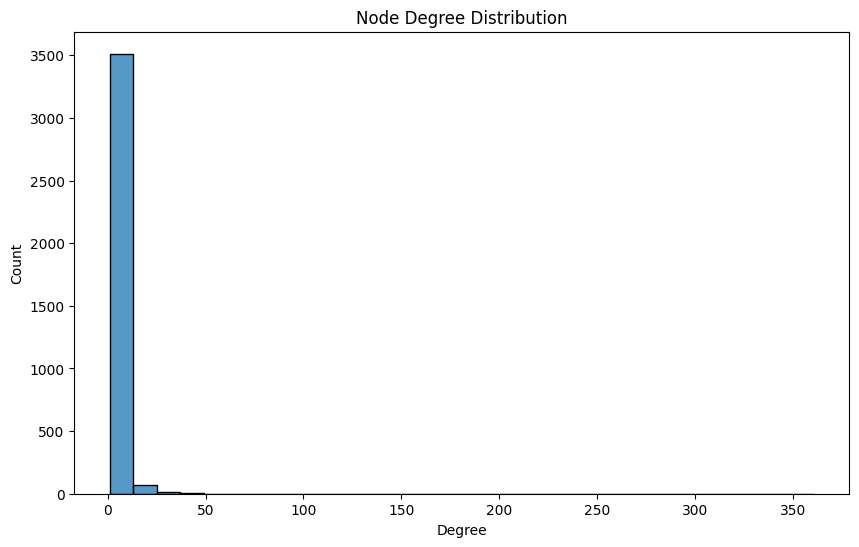

label
1    0.5
0    0.5
Name: proportion, dtype: float64


In [62]:
# Graph Information
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Node Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
sns.histplot(degrees, kde=False, bins=30)
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

# Label distribution
print(train_set['label'].value_counts(normalize=True))

In [50]:
degrees = [G.degree(n) for n in G.nodes()]

isolated_nodes = degrees == 0

# Convert the isolated_nodes variable to a tensor
isolated_nodes = torch.tensor(isolated_nodes)

# Get the indices of the isolated nodes
isolated_nodes = isolated_nodes.nonzero().flatten()

# Print the indices of the isolated nodes
print(isolated_nodes)

tensor([], dtype=torch.int64)


## II - Feature Engineering

In [49]:
# Cosine Similarity
def calculate_cosine_similarity(node_encodings, source_node, target_node):
    source_vector = node_encodings.loc[source_node].values.reshape(1, -1)
    target_vector = node_encodings.loc[target_node].values.reshape(1, -1)
    return cosine_similarity(source_vector, target_vector)[0][0]

train_set['cosine_similarity'] = train_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)

In [50]:
def common_neighbors(G, u, v):
        return len(list(nx.common_neighbors(G, u, v)))

train_set['common_neighbors'] = train_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors
0,939,3809,1,0.000000,0
1,2442,5784,1,0.308607,1
2,179,3809,1,0.000000,2
3,857,2280,1,0.000000,0
4,1358,5722,1,0.288675,0


In [51]:
# Add node degree for source and target to the train_set
degree_dict = dict(G.degree())
train_set['source_degree'] = train_set['source'].apply(lambda x: degree_dict.get(x, 0))
train_set['target_degree'] = train_set['target'].apply(lambda x: degree_dict.get(x, 0))


# Calculate Jaccard coefficient
train_set['jaccard_coefficient'] = [list(nx.jaccard_coefficient(G, [(row['source'], row['target'])]))[0][2] for index, row in train_set.iterrows()]

train_set.head()

,source,target,label,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient
0,939,3809,1,0.000000,0,1,361,0.00000
1,2442,5784,1,0.308607,1,7,4,0.10000
2,179,3809,1,0.000000,2,4,361,0.00551
3,857,2280,1,0.000000,0,7,17,0.00000
4,1358,5722,1,0.288675,0,2,13,0.00000


In [52]:
def calculate_preferential_attachment(G, source_node, target_node):
    return G.degree(source_node) * G.degree(target_node)

train_set['preferential_attachment'] = train_set.apply(lambda row: calculate_preferential_attachment(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient,preferential_attachment
0,939,3809,1,0.000000,0,1,361,0.00000,361
1,2442,5784,1,0.308607,1,7,4,0.10000,28
2,179,3809,1,0.000000,2,4,361,0.00551,1444
3,857,2280,1,0.000000,0,7,17,0.00000,119
4,1358,5722,1,0.288675,0,2,13,0.00000,26


In [84]:
def calculate_shortest_path_length_exclude_direct(G, source_node, target_node):
    # Make a copy of the graph to preserve the original graph structure
    G_modified = G.copy()
    
    # Temporarily remove the direct edge if it exists
    if G_modified.has_edge(source_node, target_node):
        G_modified.remove_edge(source_node, target_node)
    
    try:
        # Calculate the shortest path length in the modified graph
        length = nx.shortest_path_length(G_modified, source=source_node, target=target_node)
    except nx.NetworkXNoPath:
        length = 10000  # Large constant for no path
    
    return length

train_set['shortest_path_length'] = train_set.apply(lambda row: calculate_shortest_path_length_exclude_direct(G, row['source'], row['target']), axis=1)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient,preferential_attachment,shortest_path_length,same_community
0,939,3809,1,0.000000,0,1,361,0.00000,361,10000,1
1,2442,5784,1,0.308607,1,7,4,0.10000,28,2,1
2,179,3809,1,0.000000,2,4,361,0.00551,1444,2,0
3,857,2280,1,0.000000,0,7,17,0.00000,119,4,0
4,1358,5722,1,0.288675,0,2,13,0.00000,26,5,0


In [85]:
import community.community_louvain as community_louvain

# Assuming G is your graph object
partition = community_louvain.best_partition(G)

def check_same_community(partition, source_node, target_node):
    return int(partition[source_node] == partition[target_node])

# Assuming train_set is your DataFrame with 'source' and 'target' columns
train_set['same_community'] = train_set.apply(
    lambda row: check_same_community(partition, row['source'], row['target']), axis=1
)
train_set.head()

,source,target,label,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient,preferential_attachment,shortest_path_length,same_community
0,939,3809,1,0.000000,0,1,361,0.00000,361,10000,1
1,2442,5784,1,0.308607,1,7,4,0.10000,28,2,1
2,179,3809,1,0.000000,2,4,361,0.00551,1444,2,1
3,857,2280,1,0.000000,0,7,17,0.00000,119,4,0
4,1358,5722,1,0.288675,0,2,13,0.00000,26,5,0


In [86]:
test_set['cosine_similarity'] = test_set.apply(lambda row: calculate_cosine_similarity(node_info, row['source'], row['target']), axis=1)
test_set['common_neighbors'] = test_set.apply(lambda row: common_neighbors(G, row['source'], row['target']), axis=1)
test_set['source_degree'] = test_set['source'].apply(lambda x: degree_dict.get(x, 0))
test_set['target_degree'] = test_set['target'].apply(lambda x: degree_dict.get(x, 0))
test_set['jaccard_coefficient'] = [list(nx.jaccard_coefficient(G, [(row['source'], row['target'])]))[0][2] for index, row in test_set.iterrows()]
test_set['preferential_attachment'] = test_set.apply(lambda row: calculate_preferential_attachment(G, row['source'], row['target']), axis=1)
test_set['shortest_path_length'] = test_set.apply(lambda row: calculate_shortest_path_length_exclude_direct(G, row['source'], row['target']), axis=1)
test_set['same_community'] = test_set.apply(lambda row: check_same_community(partition, row['source'], row['target']), axis=1)

test_set.head()

,source,target,cosine_similarity,common_neighbors,source_degree,target_degree,jaccard_coefficient,preferential_attachment,shortest_path_length,same_community
0,3425,4524,0.204124,0,1,2,0.0,2,4,0
1,1620,2617,0.000000,0,2,2,0.0,4,5,0
2,4832,6317,0.182574,0,1,2,0.0,2,6,0
3,4984,7298,0.471405,0,1,4,0.0,4,5,0
4,385,5481,0.353553,0,2,1,0.0,2,6,0


## III - Data Modelling

### a) Random Baseline

In [57]:
###################
# random baseline #
###################

# Load test samples 
with open("../test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]

# Make random predictions
random_predictions = np.random.choice([0, 1], size=len(test_set))
random_pred = zip(np.array(range(len(test_set))), random_predictions)

# note: Kaggle requires that you add "ID" and "category" column headers

with open("random_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in random_pred:
         csv_out.writerow(row)
    pred.close()
    
random_predictions

array([0, 0, 1, ..., 0, 1, 1])

### b) XG Boost

In [106]:
from xgboost import XGBClassifier

def edge_prediction(train_set, test_col, plot_roc=True):
    # Assuming 'test_col' is defined outside this function and contains the feature column names
    msk = np.random.rand(len(train_set)) < 0.8
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[test_col].values
    test_features = test_samples[test_col].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values

    # --- Build the model and train it ---
    # Here are some basic parameters, but consider tuning these for your specific problem
    clf = XGBClassifier(
        n_estimators=100,  # Number of trees to train
        max_depth=6,  # Depth of each tree
        learning_rate=0.001,  # Learning rate
        subsample=0.8,  # Subsample ratio of the training instances
        colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
        use_label_encoder=False,  # Avoids a deprecation warning
        eval_metric='logloss'  # Metric used for evaluation (logloss for binary classification)
    )
    clf.fit(train_features, train_labels)
    
    feature_importances = clf.feature_importances_
    important_features = [test_col[i] for i in range(len(test_col)) if feature_importances[i] > 0.01]
    print("Important features:", important_features)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the ROC Curve from prediction scores ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc
    
    # Plotting the ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

/Users/victor/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Important features: ['preferential_attachment', 'shortest_path_length', 'same_community']


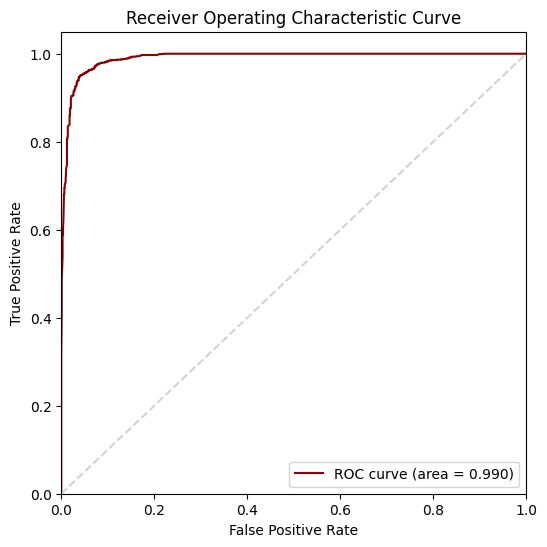

0.9486692015209125


In [108]:
test_col = ['cosine_similarity', 'target_degree', 'preferential_attachment', 'shortest_path_length', 'same_community']
roc_auc, test_accuracy, clf = edge_prediction(train_set, test_col)

print(test_accuracy)

In [109]:
test_features = test_set[test_col].values
test_preds_values = clf.predict(test_features)
print(test_preds_values)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

[0 0 0 ... 1 0 0]


In [110]:
with open("xgb6_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()

In [104]:
from sklearn.ensemble import RandomForestClassifier

def edge_prediction_rf(train_set, test_col, plot_roc=True):
    # Splitting the dataset into training and testing
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[test_col].values
    test_features = test_samples[test_col].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    # --- Build the model and train it ---
    clf = RandomForestClassifier(
        n_estimators=100,  # Number of trees in the forest
        max_depth=4,  # Maximum depth of the trees. 'None' means no limit.
        min_samples_split=2,  # Minimum number of samples required to split an internal node
        min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
        max_features='auto',  # Number of features to consider when looking for the best split
        bootstrap=True,  # Whether bootstrap samples are used when building trees
        random_state=42  # Controls both the randomness of the bootstrapping and the features selected for splitting.
    )
    clf.fit(train_features, train_labels)
    
    feature_importances = clf.feature_importances_
    important_features = [test_col[i] for i in range(len(test_col)) if feature_importances[i] > 0.01]
    print("Important features:", important_features)

    train_preds = clf.predict_proba(train_features)[:, 1]
    test_preds = clf.predict_proba(test_features)[:, 1]
    
    test_preds_values = clf.predict(test_features)
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the ROC Curve from prediction scores ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc, test_accuracy
    
    # Plotting the ROC curve
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf


/Users/victor/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Important features: ['common_neighbors', 'source_degree', 'target_degree', 'jaccard_coefficient']


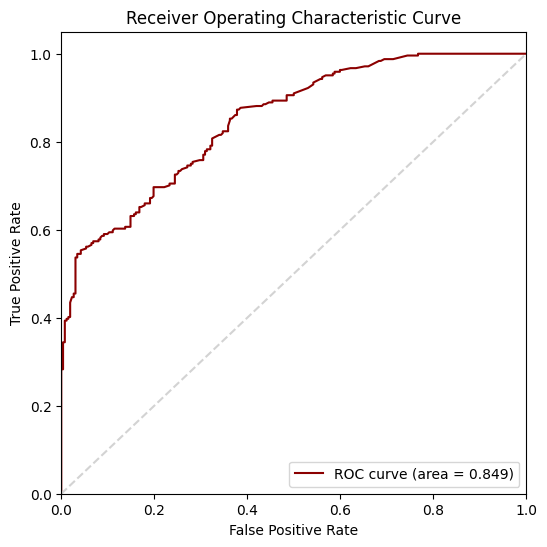

0.7391304347826086


In [105]:
test_col = ['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']
roc_auc, test_accuracy, clf_rf = edge_prediction_rf(train_set, test_col)

print(test_accuracy)

In [21]:
test_features = test_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
test_preds_values = clf_rf.predict(test_features)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

In [22]:
with open("rf_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()

### c) Graph Neural Network

In [82]:
import itertools

In [73]:
import scipy.sparse as sp

u, v = graph.edges()

eids = np.arange(graph.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = graph.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
num_nodes = graph.number_of_nodes()

# Create the adjacency matrix with an explicit shape
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(num_nodes, num_nodes))

# Now, when subtracting from a dense matrix of ones and the identity matrix, shapes will match
adj_neg = 1 - adj.todense() - np.eye(num_nodes)
neg_u, neg_v = np.where(adj_neg != 0)

# The rest of your code for selecting negative edges can remain the same
neg_eids = np.random.choice(len(neg_u), graph.number_of_edges())

test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]


In [75]:
train_g = dgl.remove_edges(graph, eids[:test_size])

In [76]:
from dgl.nn import SAGEConv

# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [77]:
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

In [78]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [79]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        """
        Computes a scalar score for each edge of the given graph.

        Parameters
        ----------
        edges :
            Has three members ``src``, ``dst`` and ``data``, each of
            which is a dictionary representing the features of the
            source nodes, the destination nodes, and the edges
            themselves.

        Returns
        -------
        dict
            A dictionary of new edge features.
        """
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [80]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [84]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(400):
    # forward
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

# ----------- 5. check results ------------------------ #
from sklearn.metrics import roc_auc_score
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

In epoch 0, loss: 0.013480952940881252
In epoch 5, loss: 0.014784072525799274
In epoch 10, loss: 0.014860432595014572
In epoch 15, loss: 0.013802215456962585
In epoch 20, loss: 0.012565577402710915
In epoch 25, loss: 0.011358710005879402
In epoch 30, loss: 0.01029219850897789
In epoch 35, loss: 0.00941479206085205
In epoch 40, loss: 0.00868209358304739
In epoch 45, loss: 0.008055089972913265
In epoch 50, loss: 0.007525525521486998
In epoch 55, loss: 0.007062880322337151
In epoch 60, loss: 0.006657246500253677
In epoch 65, loss: 0.006297663319855928
In epoch 70, loss: 0.005978823639452457
In epoch 75, loss: 0.005691058933734894
In epoch 80, loss: 0.005430100951343775
In epoch 85, loss: 0.005191666539758444
In epoch 90, loss: 0.004972563125193119
In epoch 95, loss: 0.004771160893142223
In epoch 100, loss: 0.004586347844451666
In epoch 105, loss: 0.004414346534758806
In epoch 110, loss: 0.004255943465977907
In epoch 115, loss: 0.004108846187591553
In epoch 120, loss: 0.003972445148974657


In [39]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes, allow_zero_in_degree=True)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [66]:
# Model parameters
in_feats = graph.ndata['feat'].shape[1]
h_feats = 16  # Hidden layer size
num_classes = 2  # Assuming binary classification for link prediction

model = GCN(in_feats, h_feats, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [68]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))])
    return F.binary_cross_entropy_with_logits(scores, labels)

def train(model, g, features, train_pos_edges, train_neg_edges, optimizer):
    model.train()
    optimizer.zero_grad()
    embeddings = model(g, features)
    pos_score = (embeddings[train_pos_edges[:, 0]] * embeddings[train_pos_edges[:, 1]]).sum(dim=1)
    neg_score = (embeddings[train_neg_edges[:, 0]] * embeddings[train_neg_edges[:, 1]]).sum(dim=1)
    loss = compute_loss(pos_score, neg_score)
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
# Assuming your dataset and graph are ready
features = graph.ndata['feat']
in_feats, h_feats, out_feats = features.shape[1], 16, 16

model = GCN(in_feats, h_feats, out_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    loss = train(model, graph, features, train_pos_edges, train_neg_edges, optimizer)
    print(f'Epoch {epoch}: Loss {loss}')


In [113]:
predictions_df = pd.DataFrame(predicted_links, columns=['Predicted'])

# Export the DataFrame to a CSV file
predictions_df.to_csv('GCN_predictions.csv', index=False)

In [197]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, out_features):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=4, dropout=0.2)
        # Concatenation will happen on the output features so the dimension will increase
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=4, concat=True, dropout=0.2)
        # Since concat is set to True, the input features of the next layer are the hidden_channels * num_heads
        self.conv3 = GATConv(hidden_channels * 4, out_features, concat=False, heads=1, dropout=0.2)  # No concatenation in the final layer

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)  # Add dropout for regularization
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)  # Add dropout for regularization
        x = self.conv3(x, edge_index)
        return torch.sigmoid(x.squeeze())

model = GAT(num_node_features=data.num_node_features, hidden_channels=64, out_features=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    loss = train()
    test_loss, auc_score = test()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, AUC: {auc_score:.4f}')

ValueError: Using a target size (torch.Size([1050])) that is different to the input size (torch.Size([3498])) is deprecated. Please ensure they have the same size.

In [194]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    test_pred = model(data.x, test_edge_index).squeeze()

# Convert predictions to probabilities using a sigmoid function (if not already done within the model)
test_pred_prob = torch.sigmoid(test_pred)

# You can set a threshold to classify edges as existing or not, e.g., threshold = 0.5
threshold = 0.5
predicted_links = (test_pred_prob >= threshold).int()

# Print or save your predictions
print(predicted_links)

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)


### e) XGBoost

In [133]:
train_set

,source,target,label
0,939,3809,1
1,2442,5784,1
2,179,3809,1
3,857,2280,1
4,1358,5722,1
...,...,...,...
10491,81,6464,0
10492,4,6433,0
10493,3341,6717,1
10494,1562,4656,0


/Users/victor/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


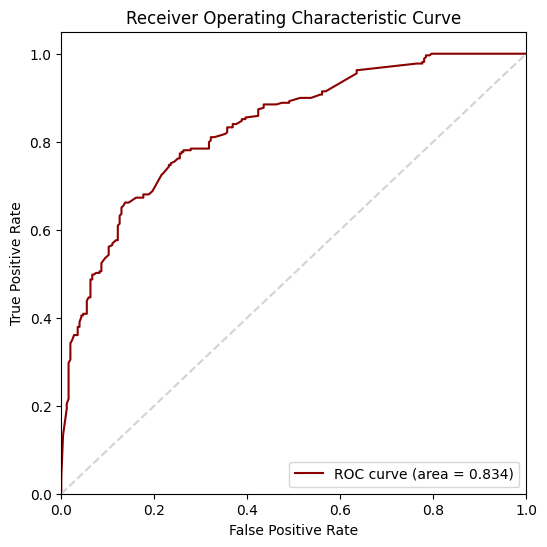

In [206]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

def edge_prediction_xgboost(train_set, plot_roc=True):
    # Splitting the dataset into training and testing
    msk = np.random.rand(len(train_set)) < 0.95
    train_samples = train_set[msk]
    test_samples = train_set[~msk]

    # Preparing features and labels
    train_features = train_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    test_features = test_samples[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
    train_labels = train_samples['label'].values
    test_labels = test_samples['label'].values
    
    learning_rate = 0.001
    max_depth = 10         
    n_estimators = 500

    # --- Build the model and train it ---
    xgb_model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    xgb_model.fit(train_features, train_labels)

    train_preds = xgb_model.predict_proba(train_features)[:, 1]
    test_preds = xgb_model.predict_proba(test_features)[:, 1]
    
    # Predicting binary values for accuracy computation
    test_preds_values = xgb_model.predict(test_features)
    
    # Compute accuracy
    test_accuracy = accuracy_score(test_labels, test_preds_values)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
    roc_auc = auc(fpr, tpr)

    if not plot_roc:
        return roc_auc, test_accuracy, clf
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc, test_accuracy, clf

# Usage
# train_set should be a DataFrame containing your features and label
 
roc_auc, test_accuracy, xgb = edge_prediction_xgboost(train_set)


In [151]:
print(test_accuracy)

0.7264748902974159


In [224]:
test_features = test_set[['cosine_similarity', 'common_neighbors', 'source_degree', 'target_degree','jaccard_coefficient']].values
test_preds_values = xgb.predict(test_features)
print(test_preds_values)
test_preds_values = zip(np.array(range(len(test_set))), test_preds_values)
test_preds_values

[0 0 0 ... 1 0 0]


In [223]:
for row in test_preds_values:
    print(row)

In [225]:
with open("xgboost_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in test_preds_values:
         csv_out.writerow(row)
    pred.close()